[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/070_model_optim/070_model_optim.ipynb)

# Pytorch - Optimización de Modelos

En posts anteriores hemos aprendido a evaluar nuestro código en `Pytorch` usando herramientas tales como el `Profiler` y `Benchmarking`. En este post seguimos aprendiendo a optimizar nuestro código, en este caso viendo cómo podemos entrenar nuestras redes neuronales más rápido.

> Las mejoras que vamos a ver sólo aplican a GPUs de NVIDIA con architectura Ampere o superior (con Tensor Cores).

In [1]:
import os
from sklearn.model_selection import train_test_split

def setup(path='./data', test_size=0.2, random_state=42):

    classes = sorted(os.listdir(path))

    print("Generating images and labels ...")
    images, encoded = [], []
    for ix, label in enumerate(classes):
        _images = os.listdir(f'{path}/{label}')
        images += [f'{path}/{label}/{img}' for img in _images]
        encoded += [ix]*len(_images)
    print(f'Number of images: {len(images)}')

     # train / val split
    print("Generating train / val splits ...")
    train_images, val_images, train_labels, val_labels = train_test_split(
        images,
        encoded,
        stratify=encoded,
        test_size=test_size,
        random_state=random_state
    )

    print("Training samples: ", len(train_labels))
    print("Validation samples: ", len(val_labels))
    
    return classes, train_images, train_labels, val_images, val_labels

classes, train_images, train_labels, val_images, val_labels = setup('./data')

Generating images and labels ...
Number of images: 27000
Generating train / val splits ...
Training samples:  21600
Validation samples:  5400


In [2]:
import torch
from skimage import io 

class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ix):
        img = io.imread(self.images[ix])[...,(3,2,1)]
        img = torch.tensor(img / 4000, dtype=torch.float).clip(0,1).permute(2,0,1)  
        label = torch.tensor(self.labels[ix], dtype=torch.long)        
        return img, label
    
ds = {
    'train': Dataset(train_images, train_labels),
    'val': Dataset(val_images, val_labels)
}

batch_size = 1024
dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=20, pin_memory=True),
    'val': torch.utils.data.DataLoader(ds['val'], batch_size=batch_size, shuffle=False, num_workers=20, pin_memory=True)
}

In [3]:
import torch.nn.functional as F
import torchvision

class Model(torch.nn.Module):

    def __init__(self, n_outputs=10):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        self.model.fc = torch.nn.Linear(2048, n_outputs)

    def forward(self, x):
        return self.model(x)

In [4]:
from tqdm import tqdm
import numpy as np

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cpu", prof=None, end=0):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        stop=False
        for batch_idx, batch in enumerate(bar):
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
            # profiling
            if prof:
                if batch_idx >= end:
                    stop = True
                    break
                prof.step()  
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        if stop:
            break
        # eval
        model.eval()
        l, a = [], []
        bar = tqdm(dl['val'])
        with torch.no_grad():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"evluating... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['val_loss'].append(np.mean(l))
        hist['val_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
        
    return hist

In [5]:
from torch.profiler import profile, record_function, ProfilerActivity

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet50'),
        record_shapes=True,
        with_stack=True
) as prof:
    hist = train(model, dl, optimizer, epochs=3, device="cuda", prof=prof, end=(1 + 1 + 3) * 2)

training... loss 0.6627 acc 0.7824:  45%|████▌     | 10/22 [00:19<00:23,  1.98s/it]


## AMP

In [6]:
def train_amp(model, dl, optimizer, epochs=10, device="cpu", use_amp = True, prof=None, end=0):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        stop=False
        for batch_idx, batch in enumerate(bar):
            optimizer.zero_grad()
            
            # AMP
            with torch.cuda.amp.autocast(enabled=use_amp):
                loss, acc = step(model, batch, device)
            scaler.scale(loss).backward()
            # gradient clipping 
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            scaler.step(optimizer)
            scaler.update()
            
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
            # profiling
            if prof:
                if batch_idx >= end:
                    stop = True
                    break
                prof.step()  
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        if stop:
            break
        # eval
        model.eval()
        l, a = [], []
        bar = tqdm(dl['val'])
        with torch.no_grad():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"evluating... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['val_loss'].append(np.mean(l))
        hist['val_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
        
    return hist

In [7]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet50_amp'),
        record_shapes=True,
        with_stack=True
) as prof:
    hist = train_amp(model, dl, optimizer, epochs=3, device="cuda", prof=prof, end=(1 + 1 + 3) * 2)

training... loss 0.6587 acc 0.7969:  45%|████▌     | 10/22 [00:20<00:24,  2.06s/it]


In [8]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
hist = train(model, dl, optimizer, epochs=3, device="cuda")

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/3 loss 0.4092 acc 0.8686 val_loss 4.8212 val_acc 0.4417


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/3 loss 0.1103 acc 0.9639 val_loss 0.5270 val_acc 0.8578


evluating... loss 0.5338 acc 0.8453: 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

Epoch 3/3 loss 0.0713 acc 0.9762 val_loss 0.5338 val_acc 0.8453


In [9]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
hist = train_amp(model, dl, optimizer, epochs=3, device="cuda")

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/3 loss 0.3996 acc 0.8700 val_loss 3.8595 val_acc 0.5055


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/3 loss 0.0915 acc 0.9722 val_loss 0.5317 val_acc 0.8495


evluating... loss 0.1512 acc 0.9594: 100%|██████████| 6/6 [00:03<00:00,  1.77it/s]

Epoch 3/3 loss 0.0770 acc 0.9759 val_loss 0.1512 val_acc 0.9594


Con `AMP` se reduce la utilización de la GPU, por lo que podemos darle más caña.

In [10]:
batch_size = 2048
dl2 = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=20, pin_memory=True),
    'val': torch.utils.data.DataLoader(ds['val'], batch_size=batch_size, shuffle=False, num_workers=20, pin_memory=True)
}

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet50_amp2'),
        record_shapes=True,
        with_stack=True
) as prof:
    hist = train_amp(model, dl2, optimizer, epochs=3, device="cuda", prof=prof, end=(1 + 1 + 3) * 2)

training... loss 0.6695 acc 0.7804:  91%|█████████ | 10/11 [00:23<00:02,  2.35s/it]


In [17]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
hist = train_amp(model, dl2, optimizer, epochs=3, device="cuda")

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/3 loss 0.6404 acc 0.7832 val_loss 58.8672 val_acc 0.3795


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/3 loss 0.0991 acc 0.9683 val_loss 6.5188 val_acc 0.6061


evluating... loss 1.6029 acc 0.7515: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Epoch 3/3 loss 0.0491 acc 0.9843 val_loss 1.6029 val_acc 0.7515


Sin `AMP` no podríamos usar un `batch size` tan grande.

In [12]:
#hist = train(model, dl2, optimizer, epochs=3, device="cuda")

In [13]:
if False:
    checkpoint = {"model": net.state_dict(),
              "optimizer": opt.state_dict(),
              "scaler": scaler.state_dict()}

    net.load_state_dict(checkpoint["model"])
    opt.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])

## Channels Last

In [14]:
def step_cl(model, batch, device):
    x, y = batch
    x, y = x.to(device, memory_format=torch.channels_last), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train_cl(model, dl, optimizer, epochs=10, device="cpu", use_amp = True, prof=None, end=0):
    model = model.to(memory_format=torch.channels_last) # Module parameters need to be channels last
    model.to(device)
    hist = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        stop=False
        for batch_idx, batch in enumerate(bar):
            optimizer.zero_grad()
            
            # AMP
            with torch.cuda.amp.autocast(enabled=use_amp):
                loss, acc = step_cl(model, batch, device)
            scaler.scale(loss).backward()
            # gradient clipping 
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            scaler.step(optimizer)
            scaler.update()
            
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
            # profiling
            if prof:
                if batch_idx >= end:
                    stop = True
                    break
                prof.step()  
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        if stop:
            break
        # eval
        model.eval()
        l, a = [], []
        bar = tqdm(dl['val'])
        with torch.no_grad():
            for batch in bar:
                loss, acc = step_cl(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"evluating... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['val_loss'].append(np.mean(l))
        hist['val_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
        
    return hist

In [15]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet50_cl'),
        record_shapes=True,
        with_stack=True
) as prof:
    hist = train_cl(model, dl, optimizer, epochs=3, device="cuda", prof=prof, end=(1 + 1 + 3) * 2)

training... loss 0.6483 acc 0.7886:  45%|████▌     | 10/22 [00:20<00:24,  2.07s/it]


In [16]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
hist = train_cl(model, dl, optimizer, epochs=3, device="cuda")

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/3 loss 0.4213 acc 0.8633 val_loss 3.0902 val_acc 0.6074


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/3 loss 0.1173 acc 0.9617 val_loss 0.2780 val_acc 0.9122


evluating... loss 1.0694 acc 0.7843: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

Epoch 3/3 loss 0.0605 acc 0.9800 val_loss 1.0694 val_acc 0.7843


In [42]:
class Dataset2(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ix):
        img = io.imread(self.images[ix])[...,(3,2,1)]
        #img = torch.tensor(img / 4000, dtype=torch.float).clip(0,1).permute(2,0,1)  
        #label = torch.tensor(self.labels[ix], dtype=torch.long)        
        return (255 * (img / 4000).clip(0, 1)).astype(np.uint8), self.labels[ix]
    
ds3 = {
    'train': Dataset2(train_images, train_labels),
    'val': Dataset2(val_images, val_labels)
}

batch_size = 32
dl3 = {
    'train': torch.utils.data.DataLoader(ds3['train'], batch_size=batch_size, shuffle=True, num_workers=20, pin_memory=True),
    'val': torch.utils.data.DataLoader(ds3['val'], batch_size=batch_size, shuffle=False, num_workers=20, pin_memory=True)
}

In [45]:
imgs, labels = next(iter(dl3['train']))
imgs.shape, labels.shape

(torch.Size([32, 64, 64, 3]), torch.Size([32]))

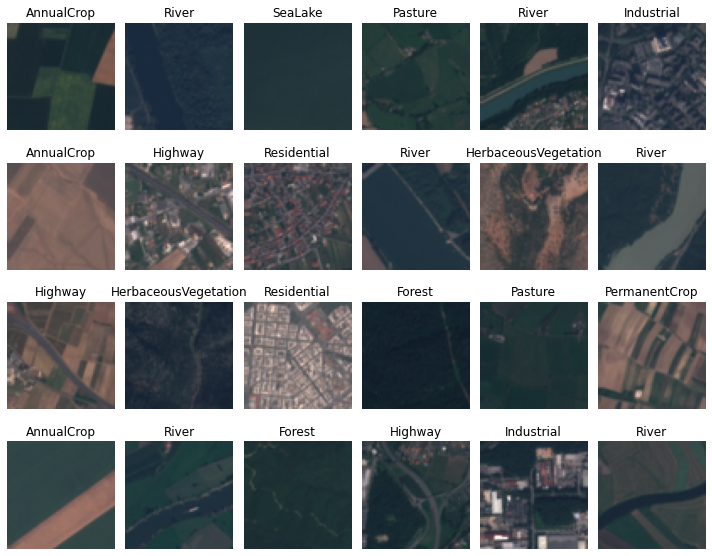

In [46]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img)
        ax.set_title(classes[label])
        ax.axis('off')
plt.tight_layout()
plt.show()

In [54]:
class Model2(torch.nn.Module):

    def __init__(self, n_outputs=10):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        self.model.fc = torch.nn.Linear(2048, n_outputs)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2).float()
        return self.model(x)

In [55]:
batch_size = 1024
dl3 = {
    'train': torch.utils.data.DataLoader(ds3['train'], batch_size=batch_size, shuffle=True, num_workers=20, pin_memory=True),
    'val': torch.utils.data.DataLoader(ds3['val'], batch_size=batch_size, shuffle=False, num_workers=20, pin_memory=True)
}

model2 = Model2()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

hist = train_amp(model2, dl3, optimizer, epochs=3, device="cuda")

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/3 loss 0.4391 acc 0.8572 val_loss 1.4384 val_acc 0.7428


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/3 loss 0.0957 acc 0.9697 val_loss 0.5344 val_acc 0.8739


evluating... loss 0.1659 acc 0.9505: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

Epoch 3/3 loss 0.0573 acc 0.9832 val_loss 0.1659 val_acc 0.9505


In [62]:
import torch.utils.benchmark as benchmark

def forward(model, x):
    y = model(x)
    
model = Model()
model = model.cuda()

batch_size = 1024
dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(ds['val'], batch_size=batch_size, shuffle=False)
}

x, _ = next(iter(dl['train']))
x = x.cuda()

t1 = benchmark.Timer(
    stmt='forward(model, x)',
    setup='from __main__ import forward',
    globals={'model': model, 'x': x})

model2 = Model2()
model2 = model2.cuda()

dl3 = {
    'train': torch.utils.data.DataLoader(ds3['train'], batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(ds3['val'], batch_size=batch_size, shuffle=False)
}

x2, _ = next(iter(dl3['train']))
x2 = x2.cuda()

t2 = benchmark.Timer(
    stmt='forward(model, x)',
    setup='from __main__ import forward',
    globals={'model': model2, 'x': x2})

print(f'float:  {t1.timeit(10)}')
print(f'unit8:  {t2.timeit(10)}')

float:  <torch.utils.benchmark.utils.common.Measurement object at 0x7f281889e100>
forward(model, x)
setup: from __main__ import forward
  146.89 ms
  1 measurement, 10 runs , 1 thread
unit8:  <torch.utils.benchmark.utils.common.Measurement object at 0x7f281a301fd0>
forward(model, x)
setup: from __main__ import forward
  500.68 ms
  1 measurement, 10 runs , 1 thread
